In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# import required libraries
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import bruges as bg

## Practical 1: Synthetic Seismic models

In this exercise you will explore how geological features appear in seismic reflection data and how their appearance differs when density, P-wave velocity, wavelet phase and frequency are varied. You will be making 2D synthetic seismic models. This exercises is done by geoscientists (in expensive software!) to explore what geological features will look like in seismic data of a particular frequency content. 2D synthetic seismic models are also used in Machine learning to provide quick and easy training data (without the need to do lots of manual labelling). We will discuss the application of Machine Learning to seismic data more on  in Lecture 7.

In this exercise you are simulating a "zero-offset" seismic experiment where sources and receivers are located at the same place just below the Earth's surface so you are only dealing with "normal-incidence" reflections. 



First, we will show you some examples and talk through them. Then you have a chance to repeat the process on yor own for a new geological model.


**Learning objectives**:
1) understand that seismic reflection data is produced by the convolution of wavelets reflected from different geological boundaries
2) Understand how reflection coefficients and velocity control the amplitude and depth of reflection in seismic profiles
3) Understand seismic vertical resolution and the limitations of the seismic reflection method

## 1.1 Creating a synthetic geological model 
We can either read in an image for the geological model or use ['bruges'](https://code.agilescientific.com/bruges/) library to create our own. Here we are using the Bruges library to create a 5 unit (ie a 5 layer) geological section- this is effectively a vertical cross-section through the Earth. In this model the thickness of some of the units is greater on the left hand side of the model than on the right and there is a slope in the centre. The model is only 40 m deep so we will be doing the equivalent of a very shallow seismic survey for an environmental/geotechnical application.

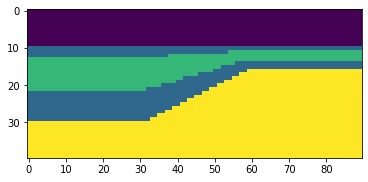

In [3]:
# Building the geological model:
model, *_ = bg.models.wedge(depth=(10, 20, 10),                     #y-axis
                            width=(30, 30, 30),                    #x-axis
                            strat=(0, (1, 2, 2, 2, 1, 1, 1,),3),    #geological units
                            thickness=(1, .3),                       #slope
                            mode='linear',                          #try: sigmoid, power, root
                            conformance='none'                      #try: top, base, 
                           )

plt.imshow(model)
plt.show()

## 1.2 P-wave Velocity and Density


The key parameters that control reflection of seismic waves are P-wave velocity and density. In Lecture 1 slide X we looked at the P-wave velocity for some common Earth materials. Density can be calculated using the Gardner relationship which you can find in lecture 1 slide x. In this example we are simlpy going to assign some velocities and densities to the units. In the later exercise you can assign your own. 

In the block below we are calculating the Acoustic Impedance (see section 1.3)

In [4]:
# Assigning the rock properties for each geological unit [density * velocity]:
rocks = np.array([1.62 * 2.00,       #geological units index 0
                  1.84 * 2.60,       #geological units index 1
                  2.90 * 5.00,       #geological units index 2
                  2.30 * 3.92        #geological units index 3
                 ])

## 1.3. Acoustic impedance

The Acoustic Impedance is the density multiplied by P-wave velocity. This parameter determines how difficult it will be for a seismic wave to travel through the rock unit. It has units of pressure.

In [5]:
# Calculating the acoustic impedance for each geological unit:
impedance = rocks[model]

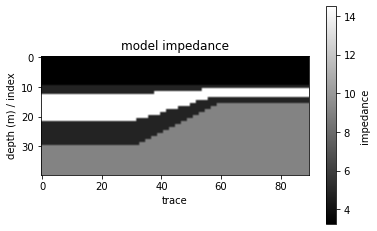

In [6]:
plt.imshow(impedance, cmap='gray', aspect=1)
plt.title('model impedance')
plt.ylabel('depth (m) / index')
plt.xlabel('trace')
plt.colorbar(label = 'impedance')
plt.show()

**Note: If you do not understand the code above please see [numpy 3d array](https://stackoverflow.com/questions/22981845/3-dimensional-array-in-numpy) and [along_axis](https://stackoverflow.com/questions/9019581/what-does-numpy-apply-along-axis-perform-exactly) guidance. 

## 1.4 Reflection coefficients

Reflection coefficients determine how much of the seismic wave will be reflected vs how much will be transmitted deeper into the Earth. The amplitude of the reflection will be the reflection coefficient multiplied by the amplitude of the incidence wave.

For "zero-offset" surveys where sources and receivers are located at the same place and we only detect "normal incidence reflections" (See lecture 1, slide x). Therefore, we can use the equation: $$ \text{ Reflection coefficient } = \frac{\rho_2 V_2 - \rho_1 V_1 }{\rho_2 V_2 + \rho_1 V_1} $$

$$\rho_1 and V_1 $$ will be the density and velocity of the upper unit and $$\rho_2 and V_2 $$ the density and velocity of the lower unit


In [7]:
# Calculating the reflection coefficient for each geological unit boundary:

rc = (impedance[1:] - impedance[:-1]) / (impedance[1:] + impedance[:-1])
rc

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## 1.5 Visualization
we have derived a variety of physical relationships. Let's take a look at the acoustic impedance and reflection coefficient as 1D profiles through the model at a particular location. 

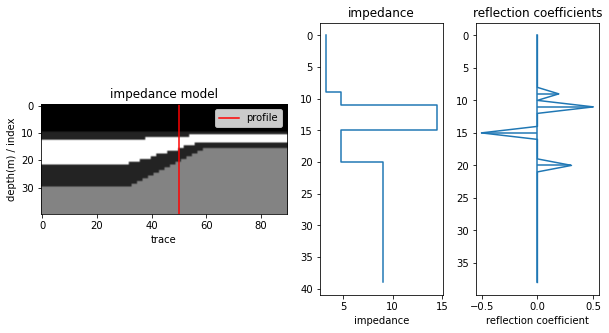

In [8]:
trace = np.shape(impedance)[1] - 40 # Try to change the trace place

fig, ax = plt.subplots(1,3, figsize=(10, 5),gridspec_kw={'width_ratios': (4, 2, 2)})

ax[0].imshow(impedance, cmap='gray')
ax[0].axvline(trace, c = 'r', label ='profile')
ax[0].set(title = 'impedance model', ylabel='depth(m) / index', xlabel = 'trace')
ax[0].legend()

ax[1].step(impedance[:,trace],  np.arange(len(impedance)), where='post')
ax[1].set (title = 'impedance', xlabel = 'impedance')
ax[1].invert_yaxis()

ax[2].stem(np.arange(len(rc)), rc[:,trace], markerfmt='', basefmt='C0-', orientation='horizontal')
ax[2].set (title = 'reflection coefficients', xlabel = 'reflection coefficient')
ax[2].invert_yaxis()
plt.show()

## 1.6 Wavelet frequency and Convolution to produce 2D synthetic seismic model


When we aquire and process seismic data we would like the source wavelet to be as close as possible to a spike function (see lecture 1, slide x). In this part of the excercise we will explore the reasons for that.

In this section we will use a wavelet function from the bruges library. There are other ways to create wavelets.

### Ricker wavelet

As we discussed in the lectures,  The Ricker wavelet is “zero-phase”, it’s max amplitude occurs at t=0. It is impossible to create during acquisition, but we can convert a minimum-phase input wavelet into a Ricker wavelet during seismic processing
some further reading if you are interested: https://academic.oup.com/gji/article/200/1/111/746485

<div class="alert alert-info"><h3>To create a Ricker wavelet you can write down your own function, or use :</h3>
<tt><a href='https://docs.scipy.org/doc/scipy-0.13.0/reference/generated/scipy.signal.ricker.html'><strong>scipy.signal.ricker</strong></a><font color=black></font>&nbsp;&nbsp;</
 or:
    </h3>
<tt><a href='https://github.com/agilescientific/bruges'><strong>bruges.filters.ricker</strong></a><font color=black></font>&nbsp;&nbsp;</div>

The duration of the wave is the length of the wave. The dt is the time sampling interval (we will talk more about that tomorrow in lecture 4). The f is the frequency in Hz.

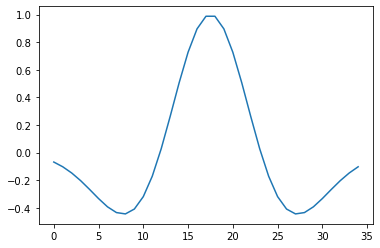

In [17]:
# Wavelet generation:
ricker = bg.filters.ricker(duration=0.07,
                              dt=0.002, 
                              f=20)
plt.plot(ricker)

We will now create the synthetic model by convolving the reflection coefficient model we made earlier with this wavelet using np.convolve

In [18]:
synth= np.apply_along_axis(np.convolve, arr=rc, axis=0, v=ricker, mode='same')

We will now display the output of the convolution at the location of the profile through the model we selected earlier

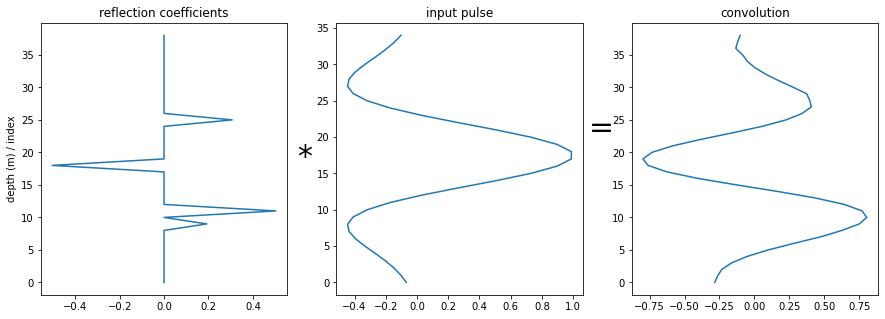

In [19]:
trace_1 = np.shape(impedance)[1]-50

fig, ax = plt.subplots(1,3, figsize=(15, 5))
ax[0].plot(rc[:,trace_1], np.arange(len(rc)))
ax[0].set (title = 'reflection coefficients', ylabel='depth (m) / index')
ax[1].plot(ricker, np.arange(len(ricker)))
ax[1].set (title = 'input pulse')
ax[2].plot(synth[:,trace_1], np.arange(len(synth)))
ax[2].set (title = 'convolution')
ax[0].text(.6, 18, '*', size=30)
ax[1].text(1.1, 20, '=', size=30)
plt.show()

As you can see, the final convolved trace at the location of our profile does NOT look like our reflection coefficient log. We see 2 positive peaks around 15 m and 32 m, a large negative around 22 m and small negative around 5m! These depths do not correlate directly to where we had our reflection coefficient non-zero values. This is caused by the convolution of a finite lenght wavelet and is a limitation of the seismic method (see lecture 1 slide x). 

If we were to increase the frequency does the convolved trace look more or less like our reflection coefficient profile??

### The 2D synthetic seismic model

We will now plot the full 2D synthetic seismic model that we have created. Does the synthetic model look like the geological model? Can you change the frequency of the wavelet to make your synthetic model look more like the geological model?

The learning objective here is that seismic reflection data will NOT look exactly like the geology because we have to use a wavelet with a finite width (we cannot produce a spike). Seismic reflection data is a bit like having a 'fuzzy' image of the subsurface- we can see the general outline of large features but cannot see the detail. IF we increase the frequency of the wavelet we can see more details BUT higher frequency wavelets get absorbed more quickly, so we can't image to great depth. 

Collecting seismic data is a compromise between using a wavelet frequency low enough to allow you to reach the depth you want, and the frequency being high enough to see the details you want. 

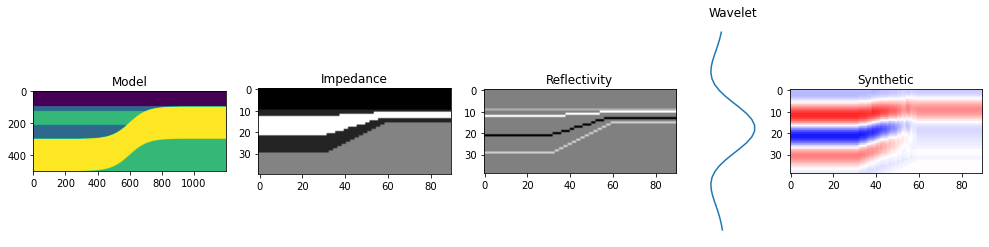

In [20]:
#Plot:

fig, axs = plt.subplots(figsize=(17, 4), ncols=5, gridspec_kw={'width_ratios': (4, 4, 4, 1, 4)})
axs[0].imshow(model)
axs[0].set_title('Model')
axs[1].imshow(impedance, cmap = 'gray')
axs[1].set_title('Impedance')
axs[2].imshow(rc, cmap = 'gray')
axs[2].set_title('Reflectivity')
axs[3].plot(ricker, np.arange(ricker.size))
axs[3].axis('off')
axs[3].set_title('Wavelet')
axs[4].imshow(synth, cmap = 'seismic', vmin = -2, vmax = 2)
axs[4].set_title('Synthetic')
plt.show()

Explore different wavelet frequencies and discuss how that changes the 2D synthetic seismic model

## It is your turn! 
#### Excersice 1: Create a 4 unit (ie 4 layer) geological model ( you are free to play around with width, slope, etc). Be creative and ask the GTAs if you would like some inspiration on what geological features like faults look like in vertical cross-sections. 

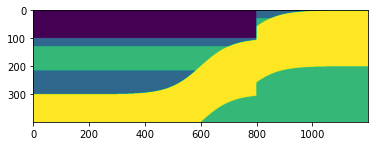

In [21]:
# Building the geological model:
model, *_ = bg.models.wedge(depth=(100, 200, 200),                     #y-axis
                            width=(300, 600, 300),                    #x-axis
                            strat=(0, (1, 2, 2, 2, 1, 1, 1,),(3,2)),    #geological units
                            thickness=(1, 0),                       #slope
                            mode='sigmoid',                          #try: sigmoid, power, root
                            conformance='top'                      #try: top, base, 
                           )

# lets include a fault in our model
model_faulted = np.zeros((np.shape(model)[0]-100, np.shape(model)[1])).astype(int)      
model_faulted[:,:800] = model[:-100,:800]
model_faulted[:,-400:] = model[100:,-550:-150]

plt.imshow(model_faulted)
plt.show()

#### Excersice 2 : In your geologial model we have the following Earth materials for each of the units: Unit 1: dry sand, Unit 2: Sandstones, Unit 3: Limestones, and Unit 4: Granite. calculate the acoustic impedance for each unit.

**Hint: To get the velocities for each of these layers look at the table in Lecture 1, slide x which comes from Kearey, Brooks and Hill- An introduction to Geophysical Exploration. To calculate density you can use the Gardner relationship ($ \rho = 0.31 V_p ^ {0.25} $) from the lecture 1, slide x. 


In [22]:
import numpy as np
def gardner(Vp):
    return 0.31*Vp**0.25

# Assigning the rock properties for each geological unit [density * velocity]:
rocks = np.array([gardner(2.00) * 2.00,       # dry sand unit index 0
                  gardner(3.00) * 3.00,       # sandstone unit index 1
                  gardner(2.50)* 2.50,       # limestone unit index 2
                  gardner(5.50) * 5.5        # granite unit index 3
                 ])
print(rocks)

[0.73730841 1.22394883 0.97451091 2.6110492 ]


#### Excersice 3: Calculate reflection coefficients for your model and visualize the reflection coefficients, and acoustic impedance alongside your model. 

**Hint: output should be a 2D array containing the reflection coefficients. 

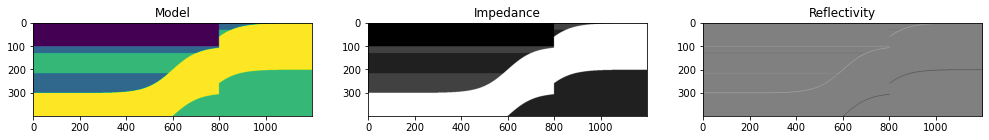

In [23]:
# Calculating the acoustic impedance for each geological unit:
impedance = rocks[model_faulted]

# Calculating the reflection coefficient for each geological unit boundary:
rc = (impedance[1:] - impedance[:-1]) / (impedance[1:] + impedance[:-1])

#Plot:

fig, axs = plt.subplots(figsize=(17, 4), ncols=3, gridspec_kw={'width_ratios': (4, 4, 4)})
axs[0].imshow(model_faulted)
axs[0].set_title('Model')
axs[1].imshow(impedance, cmap = 'gray')
axs[1].set_title('Impedance')
axs[2].imshow(rc, cmap = 'gray')
axs[2].set_title('Reflectivity')
plt.show()

#### Excersice 4: Create a wavelet with your preferred method and try different frequencies to see how this changes the 2D synthetic seismic model. Explain your findings below.**


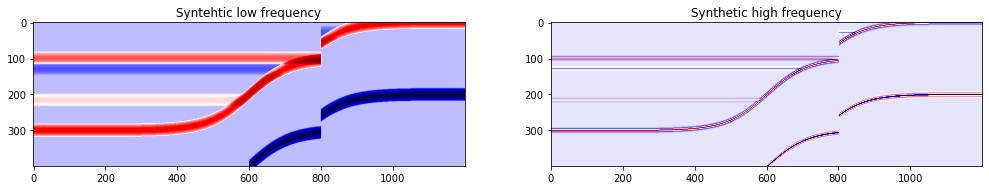

In [26]:
# Wavelet generation:
ricker_low_f = bg.filters.ricker(duration=0.07,dt=0.002, f=5)
ricker_high_f= bg.filters.ricker(duration=0.07,dt=0.002, f=50)

# Convolution
synth_low_f= np.apply_along_axis(np.convolve, arr=rc, axis=0, v=ricker_low_f, mode='same')
synth_high_f= np.apply_along_axis(np.convolve, arr=rc, axis=0, v=ricker_high_f, mode='same')

# plot results
fig, axs = plt.subplots(figsize=(17, 4), ncols=2, gridspec_kw={'width_ratios': (4, 4)})
axs[0].imshow(synth_low_f, cmap = 'seismic')
axs[0].set_title('Syntehtic low frequency')
axs[1].imshow(synth_high_f, cmap = 'seismic')
axs[1].set_title('Synthetic high frequency')
plt.show()

#### Excersice 5: If you have time try different wavelets- such as ormsby or klauder. Does the synthetic model produced with a Ricker wavelet better approximate the geological model?

(128,)


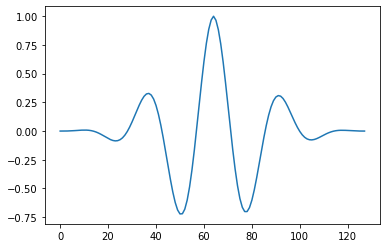

In [31]:
plt.plot(klauder)
print (klauder.shape)

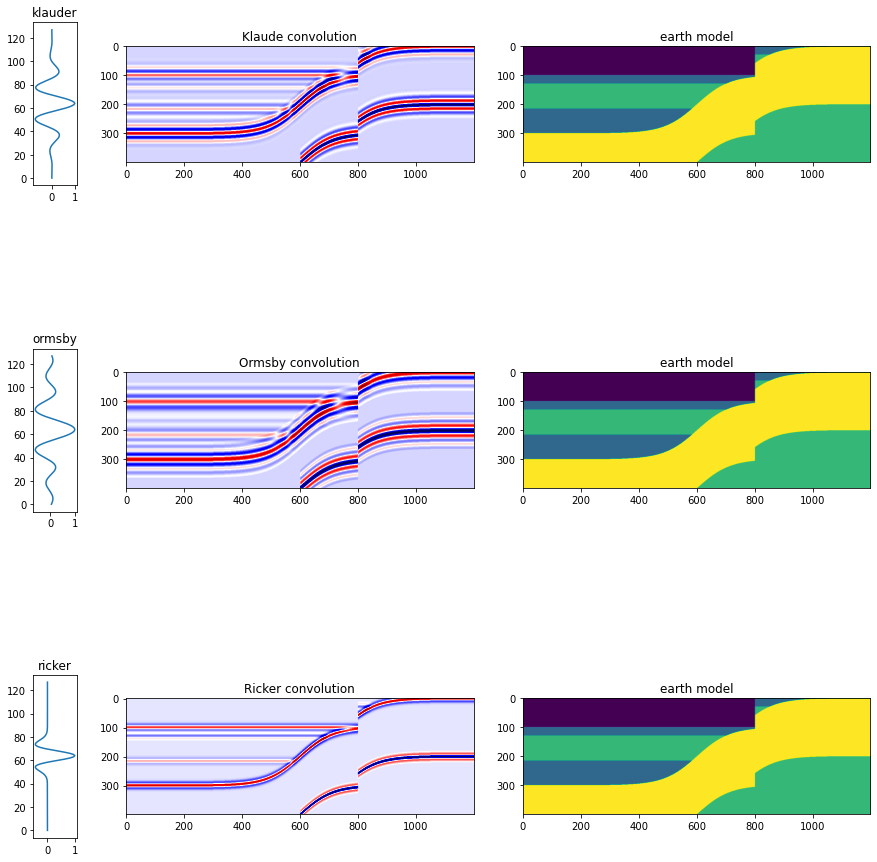

In [28]:
klauder = bg.filters.klauder(0.256, 0.002, [15,20]) # exxagerated to show the effect better
ormsby = bg.filters.ormsby(0.256, 0.002, [1, 15, 18,20]) # exxagerated to show the effect better
ricker = bg.filters.ricker(duration=0.256,dt=0.002, f=20)

# Convolution
synth_klaud= np.apply_along_axis(np.convolve, arr=rc, axis=0, v=klauder, mode='same')
synth_ormsby= np.apply_along_axis(np.convolve, arr=rc, axis=0, v=ormsby, mode='same')
synth_ricker= np.apply_along_axis(np.convolve, arr=rc, axis=0, v=ricker, mode='same')

# plot results
fig, axs = plt.subplots(3,3, figsize =(15,15), gridspec_kw={'width_ratios': (0.5, 4, 4)})

axs[0][0].plot(klauder, np.arange(len(klauder)))
axs[0][0].set_title('klauder')
axs[0][1].imshow(synth_klaud, cmap = 'seismic')
axs[0][1].set_title('Klaude convolution')
axs[0][2].imshow(model_faulted)
axs[0][2].set_title('earth model')

axs[1][0].plot(ormsby, np.arange(len(ormsby)))
axs[1][0].set_title('ormsby')
axs[1][1].imshow(synth_ormsby, cmap = 'seismic')
axs[1][1].set_title('Ormsby convolution')
axs[1][2].imshow(model_faulted)
axs[1][2].set_title('earth model')

axs[2][0].plot(ricker, np.arange(len(ricker)))
axs[2][0].set_title('ricker')
axs[2][1].imshow(synth_ricker, cmap = 'seismic')
axs[2][1].set_title('Ricker convolution')
axs[2][2].imshow(model_faulted)
axs[2][2].set_title('earth model')

fig.subplots_adjust(hspace=1)
plt.show()

Although the effect seen by the ormsby and klauder wavelet have been slightly exaggerated above to demonstrate their behaviour better. We can appreciate that for the same maximum frequency the ricker wavelet has the sharpest peak with minimal disturbance around it leading to a clearer boundary. So for our purpose we prefer the Ricker wavelet.

This does not mean that the other wavelets do not serve a purpose however. To read further into this please see [here](http://www.dim.uchile.cl/~fmaldonado/Documentos/trabajos/lab/sep94-choice-of-wavelets.pdf)

In [ ]:
plt.plot(klauder)
plt.show()